In [71]:
from PIL import Image
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
from skimage.transform import resize
import skimage
import pylab
pylab.rcParams['figure.figsize'] = (4.0, 4.0)
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torchvision.transforms as tvt
import torchvision
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import copy
import gc
import cv2 as cv
import json
import time

### Something to improve:

#### a), currently using batch_size = 10, need to explore if this is the best parameter.

#### b), a dedicated model for image classification may gives better classification accuracy.

#### c), limited by the computation power, I only calculated for maximally 5 epochs. The result will be better if I can calculate for more epochs with a lower learning rate. From the training process, the validation classification can goes to 0.92 temperarily, but decreased after more epochs, indicating large learning rate. 

In [433]:
train_json = '*\\annotations\\instances_train2014.json'
val_json = '*\\annotations\\instances_val2014.json'

train2014 = '*\\train2014'
val2014 = '*\\val2014'

train_path = '*\\train'
val_path = '*\\val'

class_list = ['pizza', 'bus', 'cat']
class_list.sort()

### 1. functions to produce image with bbox and label

In [448]:
def test_an_img_net(cat, net):
    
    # load an image from dataloader
    kwargs = {'batch_size': 1,
              'shuffle': True,
              'drop_last': True}
    train_data_loader = torch.utils.data.DataLoader(dataset = train_dataset, **kwargs)
    train_iter = iter(train_data_loader)
    
    label = -1
    while label != cat:
        imgs, labels, bboxs = next(train_iter)
        label = labels.item()
   
    # original image
    # img = imgs[0,:,:,:].permute(1, 2, 0).numpy() # from 4d tensor to 3d numpy image
    img = imgs[0,:,:,:].permute(1, 2, 0).numpy()
    img = np.uint8((img + 1)*0.5*255) # int8
    
    # original bbox
    x1,y1,x2,y2 = np.uint16(bboxs[0].numpy()*255)
    
    output_cls, output_reg = net(imgs)
    label_pred = torch.argmax(output_cls, dim=1).item()
    x1_pred, y1_pred, x2_pred, y2_pred = np.uint16(output_reg[0].detach().numpy()*255)
    
    return img, label, label_pred, (x1,y1,x2,y2), (x1_pred, y1_pred, x2_pred, y2_pred)


def draw_box_label_net(cat, net):

    img, label, label_pred, (x1,y1,x2,y2), (x1_pred, y1_pred, x2_pred, y2_pred) = test_an_img_net(cat, net)    

    img = np.uint8(img).copy() 

    img = cv.rectangle(img, (x1, y1), (x2, y2), (36,255,12), 2)
    img = cv.putText(img, class_list[label], (int(x1+10), int(y1+20)), cv.FONT_HERSHEY_SIMPLEX, 0.8, (36,255,12),2)

    img = cv.rectangle(img, (x1_pred, y1_pred), (x2_pred, y2_pred), (0,0,255), 2)
    img = cv.putText(img, class_list[label_pred], (int(x1_pred+10), int(y1_pred+20)), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255),2)
    
    return img


def test_an_img(cat):
    
    # load an image from dataloader
    kwargs = {'batch_size': 1,
              'shuffle': True,
              'drop_last': True}
    train_data_loader = torch.utils.data.DataLoader(dataset = train_dataset, **kwargs)
    train_iter = iter(train_data_loader)
    
    label = -1
    while label != cat:
        imgs, labels, bboxs = next(train_iter)
        label = labels.item()
   
    # original image
    # img = imgs[0,:,:,:].permute(1, 2, 0).numpy() # from 4d tensor to 3d numpy image
    img = imgs[0,:,:,:].permute(1, 2, 0).numpy()
    img = np.uint8((img + 1)*0.5*255) # int8
    
    # original bbox
    x1,y1,x2,y2 = np.uint16(bboxs[0].numpy()*255)
    
    return img, label, (x1,y1,x2,y2)

def draw_box_label(cat):

    img, label, (x1,y1,x2,y2) = test_an_img(cat)    

    img = np.uint8(img).copy() 

    img = cv.rectangle(img, (x1, y1), (x2, y2), (36,255,12), 2)
    img = cv.putText(img, class_list[label], (int(x1+10), int(y1+20)), cv.FONT_HERSHEY_SIMPLEX, 0.8, (36,255,12),2)

    return img

### 2, select train and validation data

In [ ]:
def selectDataset(path_anno):
    class_list = ['pizza', 'bus', 'cat']
    class_list.sort()
    coco = COCO(path_anno)
    
    catIds = coco.getCatIds(catNms = class_list) 
    
    '''
    select images from three categories and following principles:
    1, the image contains only one object from one category.
    2, the object bbox size should be larger than 200*200
    '''
    select_imgIds = []

    for i in range(3):
        cat_imgIds = []
        imgIds = coco.getImgIds(catIds = catIds[i])
        for imgId in imgIds:
            annIds = coco.getAnnIds(imgIds = imgId, catIds = catIds[i], iscrowd = False)
            anns = coco.loadAnns(annIds)
            annIds2 = coco.getAnnIds(imgIds = imgId, catIds = catIds[(i+1)%3], iscrowd = False)
            annIds3 = coco.getAnnIds(imgIds = imgId, catIds = catIds[(i+2)%3], iscrowd = False)
            anns2 = coco.loadAnns(annIds2)
            anns3 = coco.loadAnns(annIds3)

            # only have one main object with a large size
            if len(anns)==1 and len(anns2)==0 and len(anns3)==0:
                if anns[0]['area'] >= 40000:
                    cat_imgIds.append(imgId)
                    
        select_imgIds.append(cat_imgIds)
    
    for i in range(3):
        print('Selected dataset Category: ' + class_list[i] + ', num of img: ' + str(len(select_imgIds[i])), end = '\n')
        
    return select_imgIds, coco, catIds

In [440]:
select_imgIds, coco, catIds = selectDataset(train_json)

loading annotations into memory...
Done (t=10.43s)
creating index...
index created!
Selected dataset Category: bus, num of img: 1045
Selected dataset Category: cat, num of img: 1148
Selected dataset Category: pizza, num of img: 908


In [442]:
select_imgIds, coco, catIds = selectDataset(val_json)

loading annotations into memory...
Done (t=4.76s)
creating index...
index created!
Selected dataset Category: bus, num of img: 560
Selected dataset Category: cat, num of img: 654
Selected dataset Category: pizza, num of img: 462


### 3. resize the selected images and put them into a new folder
-- This operation only needs to be run for one time

In [443]:
def createDataset(path_old, path_new, path_anno):
    
    class_list = ['pizza', 'bus', 'cat']
    class_list.sort()
    coco = COCO(path_anno)
    
    catIds = coco.getCatIds(catNms = class_list) 
    
    '''
    select images from three categories and following principles:
    1, the image contains only one object from one category.
    2, the object bbox size should be larger than 200*200
    '''
    select_imgIds = []

    for i in range(3):
        cat_imgIds = []
        imgIds = coco.getImgIds(catIds = catIds[i])
        for imgId in imgIds:
            annIds = coco.getAnnIds(imgIds = imgId, catIds = catIds[i], iscrowd = False)
            anns = coco.loadAnns(annIds)
            annIds2 = coco.getAnnIds(imgIds = imgId, catIds = catIds[(i+1)%3], iscrowd = False)
            annIds3 = coco.getAnnIds(imgIds = imgId, catIds = catIds[(i+2)%3], iscrowd = False)
            anns2 = coco.loadAnns(annIds2)
            anns3 = coco.loadAnns(annIds3)

            # only have one main object with a large size
            if len(anns)==1 and len(anns2)==0 and len(anns3)==0:
                if anns[0]['area'] >= 40000:
                    cat_imgIds.append(imgId)
                    
        select_imgIds.append(cat_imgIds)
    
    for i in range(3):
        print('Selected dataset Category: ' + class_list[i] + ', num of img: ' + str(len(select_imgIds[i])), end = '\n')

    for i in range(len(select_imgIds)):
        for j in range(len(select_imgIds[i])):
            imgId = select_imgIds[i][j]
            img = coco.loadImgs(imgId)[0]
            H, W = img['height'],img['width']

            os.chdir(path_old)
            I = io.imread(img['file_name'])
            # convert from gray to color if needed
            if len(I.shape) == 2:
                I = skimage.color.gray2rgb(I)
            
            # resize to 256*256
            I_resize = 255*resize(I, (256,256), anti_aliasing=True)
            I_resize = I_resize.astype(np.uint8)
            
            # save to new foler
            os.chdir(path_new)
            io.imsave(img['file_name'],I_resize)
            
    print('-'*20 + 'Done' + '-'*20)

In [45]:
# validation set
# createDataset(path_old = val2014, path_new = val_path, path_anno = val_json)

loading annotations into memory...
Done (t=5.05s)
creating index...
index created!
Selected dataset Category: bus, num of img: 560
Selected dataset Category: cat, num of img: 654
Selected dataset Category: pizza, num of img: 462
--------------------Done--------------------


In [38]:
# training
# createDataset(path_old = train2014, path_new = train_path, path_anno = train_json)

loading annotations into memory...
Done (t=10.94s)
creating index...
index created!
Selected dataset Category: bus, num of img: 1045
Selected dataset Category: cat, num of img: 1148
Selected dataset Category: pizza, num of img: 908
--------------------Done--------------------


### 4, extract label and bbox for train and validation data

In [439]:
'''
input: path_old, path_anno
output: data_paths, data_labels, data_bboxs
'''

def extract_label_bbox(path_old, path_anno):
    select_imgIds, coco, catIds = selectDataset(path_anno)
    
    data_paths = []
    data_labels = {}
    data_bboxs = {}
    
    for i in range(len(select_imgIds)):
        for j in range(len(select_imgIds[i])):
            imgId = select_imgIds[i][j]
            img = coco.loadImgs(imgId)[0]
            H, W = img['height'],img['width']
            
            annIds = coco.getAnnIds(imgIds = imgId, catIds = catIds[i], iscrowd = False)
            anns = coco.loadAnns(annIds)
            [x1,y1,dx,dy] = anns[0]['bbox']
            
            x2 = x1+dx
            y2 = y1+dy
            
            file_name = img['file_name']
            data_paths.append(file_name)
            data_labels[file_name] = i
            # data_bboxs[file_name] = (int(x1*256/W), int(y1*256/W), int(x2*256/W), int(y2*256/W))
            data_bboxs[file_name] = np.array([x1/W, y1/H, x2/W, y2/H])
            
    return data_paths, data_labels, data_bboxs

In [18]:
train_paths, train_labels, train_bboxs = extract_label_bbox(path_old = train2014, path_anno = train_json)
random.shuffle(train_paths)

loading annotations into memory...
Done (t=11.40s)
creating index...
index created!
Selected dataset Category: bus, num of img: 1045
Selected dataset Category: cat, num of img: 1148
Selected dataset Category: pizza, num of img: 908


In [19]:
val_paths, val_labels, val_bboxs = extract_label_bbox(path_old = val2014, path_anno = val_json)
random.shuffle(val_paths)

loading annotations into memory...
Done (t=6.76s)
creating index...
index created!
Selected dataset Category: bus, num of img: 560
Selected dataset Category: cat, num of img: 654
Selected dataset Category: pizza, num of img: 462


### 5, build dataloader

In [ ]:
# create dataset class
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, folder_path, data_paths, data_labels, data_bboxs , train = True):
        super(MyDataset).__init__()
        self.folder_path = folder_path
        self.data_paths = data_paths
        self.data_labels = data_labels
        self.data_bboxs = data_bboxs
        
        # to tensor and normalize the image
        self.transform = tvt.Compose([tvt.ToTensor(),
                                      tvt.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])])
            
    def __len__(self):
        # return total num of images
        return len(self.data_paths)
    
    def __getitem__(self, index):
        # Read an image at index and perform augmentations
        path = os.path.join(self.folder_path, self.data_paths[index])
        img = Image.open(path)
        
        # return the tuple: augmented tensor, integer label
        img = self.transform(img)
        label = self.data_labels[self.data_paths[index]]
        bbox = torch.from_numpy(self.data_bboxs[self.data_paths[index]]).to(torch.float32)
        
        return img, label, bbox

In [444]:
train_dataset = MyDataset(train_path, train_paths, train_labels, train_bboxs)
val_dataset = MyDataset(val_path, val_paths, val_labels, val_bboxs)

In [445]:
kwargs = {'batch_size': 10,
          'shuffle': True,
          'drop_last': True}
train_data_loader = torch.utils.data.DataLoader(dataset = train_dataset2, **kwargs)

### 7, Plot 3 cat* 3 images for the training dataset using dataloader

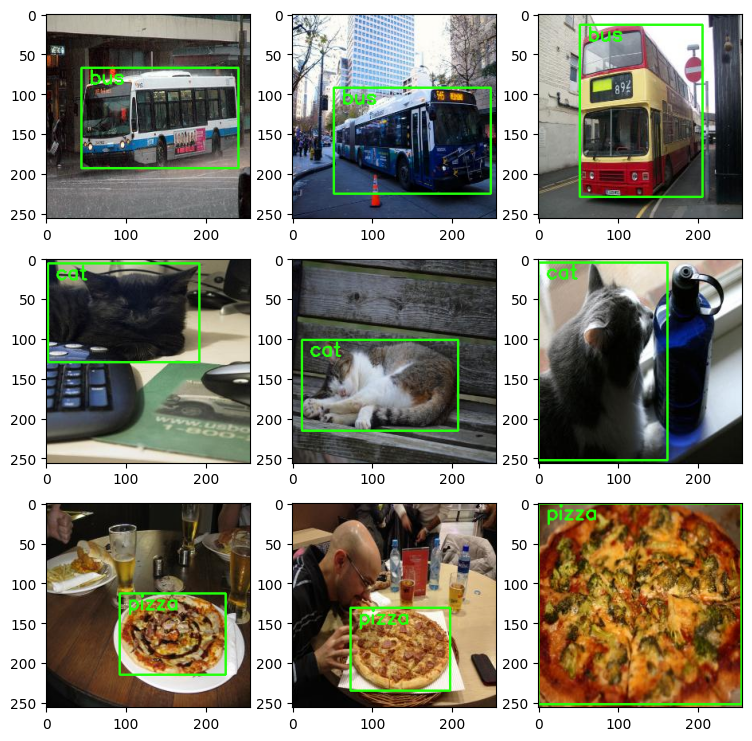

In [450]:
fig,ax = plt.subplots(3,3, figsize = (9,9))
for j in range(3):
    for i in range(3):
        img = draw_box_label(j) 
        ax[j][i].imshow(img)

### 8, Model with resnet block and contain both classification head and regression head (bbox)

#### the number of layers is 58

In [455]:
class ResnetBlock2(nn.Module):
    def __init__(self, in_ch, out_ch, downsample):
        super(ResnetBlock2, self).__init__()
        self.in_ch = in_ch
        self.out_ch = out_ch
        self.downsample = downsample
        self.Conv1 = nn.Conv2d(in_ch, out_ch, kernel_size = 3, stride = 1, padding = 1)
        self.Conv2 = nn.Conv2d(out_ch, out_ch, kernel_size = 3, stride = 1, padding = 1)
        
        self.relu = nn.ReLU(True)
        self.BN1 = nn.BatchNorm2d(out_ch)
        self.BN2 = nn.BatchNorm2d(out_ch)
        
        self.downsampler = nn.Conv2d(in_ch, out_ch, kernel_size = 3, stride=2, padding = 1)
        
    def forward(self, x):
        in_copy = x
   
        out = self.Conv1(x)
        out = self.BN1(out)
        out = self.relu(out)
        
        out = self.Conv2(out)
        out = self.BN2(out)
        
        if self.downsample:
            out = self.downsampler(out)
            in_copy = self.downsampler(in_copy)
            
        #################  key of resnet #########################    
        if self.in_ch == self.out_ch:
            out = out  + in_copy
        # in this program out_ch = in_ch*2
        else:
            out[:,:self.in_ch,:,:] += in_copy
            out[:,self.in_ch:,:,:] += in_copy
            
        out = self.relu(out)
        return out

class Net(nn.Module):
    '''Resnet-based encoder that consists of a few downsampling + several Resnet blocks as the backbone
    and two prediction heads'''
    
    def __init__(self, input_nc, ngf = 8, n_blocks = 2):
        '''
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            ngf (int)       -- the number of filters in the first conv layer
            n_blocks (int)  -- the number of ResNet blocks
        '''
        
        assert (n_blocks >= 0)
        super(Net, self).__init__()
        
        # first convolution layer
        model = [nn.ReflectionPad2d(3),
                nn.Conv2d(input_nc, ngf, kernel_size = 7, padding = 1),
                nn.BatchNorm2d(ngf),
                nn.ReLU(True)]
        
        # downsampling layer
        n_downsampling = 4
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf*mult, ngf*mult*2, kernel_size = 3, stride = 2, padding = 1),
                     nn.BatchNorm2d(ngf*mult*2),
                     nn.ReLU(True)]
        
        # ResNet
        mult = ngf * 2**n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock2(mult, mult, downsample = False)]
        
        self.model = nn.Sequential(*model)
        

        # classification head
        class_head = [nn.Conv2d(mult, mult, kernel_size=3, padding=1),
                      nn.BatchNorm2d(mult),
                      nn.ReLU(True),
                      nn.Conv2d(mult, mult, kernel_size=3, padding=1),
                      nn.BatchNorm2d(mult),
                      nn.ReLU(True),
                      nn.Flatten(1,-1),
                      nn.Linear(36992, 1024),
                      nn.ReLU(True),
                      nn.Linear(1024, 3)]
        
        self.class_head = nn.Sequential(*class_head)
        
        # bounding box regression head
        bbox_head = [nn.Flatten(1,-1),
                    nn.Linear(36992, 1024),
                    nn.ReLU(True),
                    nn.Linear(1024, 512),
                    nn.ReLU(True),
                    nn.Linear(512, 4)] # 4 for four coordinate x1,y1,x2,y2
        
        self.bbox_head = nn.Sequential(*bbox_head)
        
    def forward(self, input):
        ft = self.model(input)
        cls = self.class_head(ft)
        bbox = self.bbox_head(ft)
        
        return cls, bbox

In [456]:
net = Net(input_nc = 3)
len(list(net.parameters()))

58

### 9, function to run training and validation

### For training, I tried both MSE loss and generalized_box_iou_loss

In [402]:
def confusion_matrix(label_true, label_pred):
    '''
    input: ground truth label, predicted label
    output: confusion matrix
    '''
    labels = list(set(list(label_true) + list(label_pred)))
    cfm = np.zeros((len(labels), len(labels)), dtype = np.int64)
    for i in range(len(label_true)):
        cfm[label_true[i],label_pred[i]] += 1
    return cfm

# MES loss for bbox
def run_training(net, lr, batch_size, epochs, myDataset_train = train_dataset, myDataset_valid = val_dataset):
    gc.collect()
    output_every = 100 # iterations
    start_time = time.time()
    
    net = copy.deepcopy(net)
    net = net.to(device)
    print('\n Num of layers for this model: ', len(list(net.parameters())),end = '\n')
    
    epochs = epochs
    
    '''
    cross entropy loss for classification,
    MSE loss for regression.
    '''
    criterion_cls = torch.nn.CrossEntropyLoss()
    criterion_cls_valid = torch.nn.CrossEntropyLoss()
    
    criterion_reg = nn.MSELoss()
    criterion_reg_valid = nn.MSELoss()
    
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    
    ''' create data loader '''
    kwargs = {'batch_size': batch_size,
              'shuffle': True,
              'drop_last': True}
    train_data_loader = torch.utils.data.DataLoader(dataset = myDataset_train, **kwargs)
    
    kwargs = {#'batch_size': len(myDataset_valid),
              'batch_size': 100,
              'shuffle': True,
              'drop_last': True}
    valid_data_loader = torch.utils.data.DataLoader(dataset = myDataset_valid, **kwargs)
    
    iter_valid = iter(valid_data_loader)
    inputs_valid, labels_valid, bboxs_valid = next(iter_valid)
    # bboxs_valid = torch.transpose(torch.stack(bboxs_valid),0,1)
    inputs_valid = inputs_valid.to(device)
    labels_valid = labels_valid.to(device)
    bboxs_valid = bboxs_valid.to(device)
       
    loss_train_cls = []
    loss_valid_cls = []
    accu_valid_cls = []
    loss_train_reg = []
    loss_valid_reg = []
         
    for epoch in range(epochs):
        running_loss_cls = 0.0
        running_loss_reg = 0.0
        iter_train = iter(train_data_loader)   
        
        for i, data in enumerate(iter_train):

            inputs, labels, bboxs = data 
            inputs = inputs.to(device)
            labels = labels.to(device)            
            optimizer.zero_grad()            
            outputs_cls, outputs_bbox = net(inputs)
            
            ''' backpropagation seperately '''
            loss_cls = criterion_cls(outputs_cls, labels)
            with torch.autograd.set_detect_anomaly(True):
                loss_cls.backward(retain_graph=True)
            
            loss_reg = criterion_reg(outputs_bbox, bboxs)
            with torch.autograd.set_detect_anomaly(True):
                loss_reg.backward()
            
            optimizer.step()
            running_loss_cls += loss_cls.item()
            running_loss_reg += loss_reg.item()

            if (i+1)%output_every == 0:
                
                outputs_cls_valid, outputs_reg_valid = net(inputs_valid)
        
                running_loss_valid_cls = criterion_cls_valid(outputs_cls_valid, labels_valid).item() 
                running_loss_valid_reg = criterion_reg_valid(outputs_reg_valid, bboxs_valid).item()           
                
                label_pred_valid = torch.argmax(outputs_cls_valid, dim=1).numpy()

                running_accu_valid_cls = accuracy_score(labels_valid.numpy(), label_pred_valid)
                
                print('[epoch: %d, batch: %d] train clf loss: %.3f'%(epoch+1, i+1, running_loss_cls/100),
                      '******** train reg loss: %.3f'%(running_loss_reg),
                      '******** valid clf loss: %.3f'%(running_loss_valid_cls),
                      '******** valid clf accu: %.3f'%(running_accu_valid_cls),
                      '******** valid reg loss: %.3f'%(running_loss_valid_reg)
                       )
                
                loss_train_cls.append(running_loss_cls/output_every)
                loss_valid_cls.append(running_loss_valid_cls)
                accu_valid_cls.append(running_accu_valid_cls)
                loss_train_reg.append(running_loss_reg/output_every)
                loss_valid_reg.append(running_loss_valid_reg)
                
                running_loss_cls = 0.0
                running_loss_reg = 0.0
    
    end_time = time.time()
    print('\n Runtime of this program: ', end_time - start_time)
    gc.collect() # release memory
        
    return net, loss_train_cls, loss_valid_cls, accu_valid_cls, loss_train_reg, loss_valid_reg


def run_validation(net, myDataset_valid = val_dataset):
    
    # create dataloader
    kwargs = {'batch_size': 100,
              # 'batch_size': len(myDataset_valid),
              'shuffle': False,
              'drop_last': False}
    valid_data_loader = torch.utils.data.DataLoader(dataset = myDataset_valid, **kwargs)
    
    # too many data, need to load data in batchs
    labels, bboxs = torch.tensor([]), torch.tensor([])
    outputs_cls, outputs_reg = torch.tensor([]), torch.tensor([])
    labels_pred = np.array([])
    
    valid_iter = iter(valid_data_loader)
    for i in range(1000):
        try: 

            inputs, label, bbox = next(valid_iter)
            output_cls, output_reg = net(inputs)   
            label_pred = torch.argmax(output_cls, dim=1).numpy()

            labels = torch.cat((labels, label))
            bboxs = torch.cat((bboxs, bbox))
            outputs_cls = torch.cat((outputs_cls, output_cls))
            outputs_reg = torch.cat((outputs_reg, output_reg))
            labels_pred = np.concatenate((labels_pred, label_pred), axis=0)
        except:
            break
    
    cf_matrix = confusion_matrix(labels.numpy().astype(np.uint8), labels_pred.astype(np.uint8))
    
    x_axis_labels = ['bus', 'cat', 'pizza'] # 
    y_axis_labels = ['bus', 'cat', 'pizza']
    s = sns.heatmap(cf_matrix, annot=True, fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    s.set(xlabel='Pred label', ylabel='True label')
    
    # criterion_reg = torchvision.ops.generalized_box_iou
    criterion_reg = torchvision.ops.box_iou
    IoU_score = torch.trace(criterion_reg(outputs_reg , bboxs))/len(myDataset_valid)
    
    print('model classification accuracy = %.3f'%accuracy_score(labels.numpy(), labels_pred), end = '\n')
    print('model mean IoU value = %.3f'%IoU_score.item())  

### 10, Training with MSE loss and validation

In [464]:
net2 = Net(input_nc = 3, n_blocks = 4)
gc.collect()
net2, loss_train_cls2, loss_valid_cls2, accu_valid_cls2, loss_train_reg2, loss_valid_reg2 = \
run_training(net = net2, lr=3e-3, batch_size=10, epochs=5, myDataset_train = train_dataset, myDataset_valid = val_dataset)


 Num of layers for this model:  78
[epoch: 1, batch: 100] train clf loss: 0.795 ******** train reg loss: 195.780 ******** valid clf loss: 0.677 ******** valid clf accu: 0.730 ******** valid reg loss: 0.032
[epoch: 1, batch: 200] train clf loss: 0.567 ******** train reg loss: 2.685 ******** valid clf loss: 0.505 ******** valid clf accu: 0.770 ******** valid reg loss: 0.024
[epoch: 1, batch: 300] train clf loss: 0.606 ******** train reg loss: 2.682 ******** valid clf loss: 0.400 ******** valid clf accu: 0.850 ******** valid reg loss: 0.023
[epoch: 2, batch: 100] train clf loss: 0.514 ******** train reg loss: 2.470 ******** valid clf loss: 0.451 ******** valid clf accu: 0.850 ******** valid reg loss: 0.022
[epoch: 2, batch: 200] train clf loss: 0.507 ******** train reg loss: 2.235 ******** valid clf loss: 0.411 ******** valid clf accu: 0.820 ******** valid reg loss: 0.024
[epoch: 2, batch: 300] train clf loss: 0.479 ******** train reg loss: 2.238 ******** valid clf loss: 0.333 ******** v

model classification accuracy = 0.864
model mean IoU value = 0.552


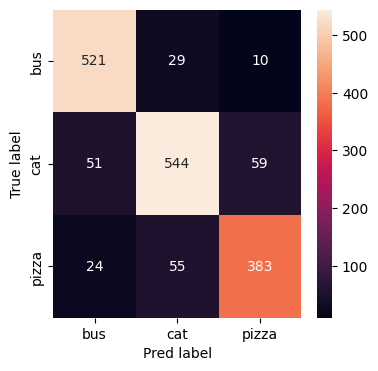

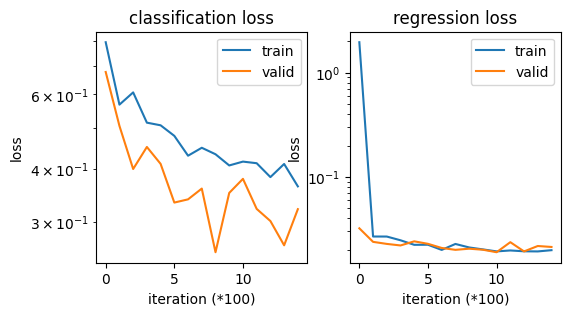

In [465]:
gc.collect()
run_validation(net2)

fig, ax = plt.subplots(1,2, figsize = (6,3))

ax[0].plot(loss_train_cls2, label = 'train')
ax[0].plot(loss_valid_cls2, label = 'valid')
ax[0].set_title('classification loss')
ax[0].set_xlabel('iteration (*100)')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[0].set_yscale('log')

ax[1].plot(loss_train_reg2, label = 'train')
ax[1].plot(loss_valid_reg2, label = 'valid')
ax[1].set_title('regression loss')
ax[1].set_xlabel('iteration (*100)')
ax[1].set_ylabel('loss')
ax[1].legend()
ax[1].set_yscale('log')

### Output of the model for 3*3 categories images
#### Note: 'green' is ground truth, 'blue' is the prediction

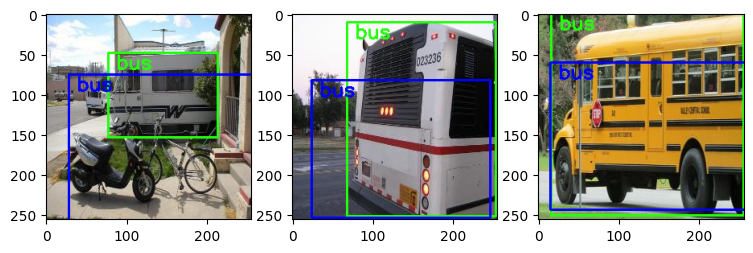

In [501]:
fig,ax = plt.subplots(1,3, figsize = (9,3))
for i in range(3):
    img = draw_box_label_net(0, net2) 
    ax[i].imshow(img)

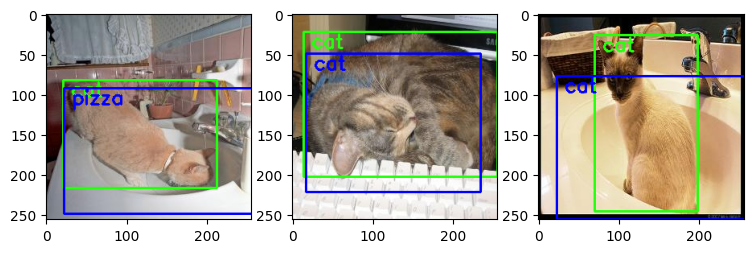

In [504]:
fig,ax = plt.subplots(1,3, figsize = (9,3))
for i in range(3):
    img = draw_box_label_net(1, net2) 
    ax[i].imshow(img)

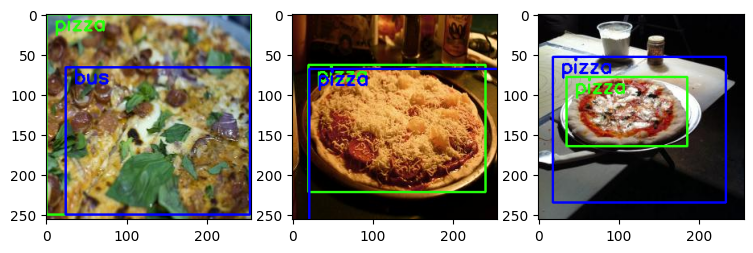

In [503]:
fig,ax = plt.subplots(1,3, figsize = (9,3))
for i in range(3):
    img = draw_box_label_net(2, net2) 
    ax[i].imshow(img)